# Super Resolution

Implementation of super resolution the following notebook is based on the article  
[Real-Time Single Image and Video Super-Resolution](https://arxiv.org/abs/1609.05158)  
[PDF](<Real-Time Single Image and Video Super-Resolution Using an Efﬁcient Sub-Pixel Convolutional Neural Network.pdf>)



## Import of modules

In [87]:
import numpy as np
import matplotlib.pyplot as plt
import torch, torchvision, torcheval
import os, sys, re

import PIL
import glob

from tqdm import tqdm
from torch.utils.data import DataLoader

# sys.path.append('supresolv')
import supresolv as sr

from supresolv.data import *
from supresolv.dataset import *
from supresolv.model import *

from torcheval.metrics.functional import peak_signal_noise_ratio, mean_squared_error

if torch.cuda.is_available():
    USE_CUDA = True

## Model definition and loading

In [88]:
# dataset download
upscale_factor = 3
train_set = get_training_set(upscale_factor)
test_set = get_test_set(upscale_factor)

# creation of dataloaders
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=True)

model = ESPCN(upscale_factor)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
mse_loss = torch.nn.MSELoss()

## Model Training

In [89]:
epochs: int = 500

for epoch in tqdm(range(epochs),"Epochs"):

    # epoch training
    for input, target in train_loader:
        # zeros all gradients
        optimizer.zero_grad()

        # propagate input in nn
        output = model(input)

        # loss calculation
        loss: torch.Tensor = mse_loss(output, target)
        loss.backward()

        # parameters update
        optimizer.step()

    # save the model for each epoch
    torch.save(
        model,
        os.path.join(
            ".models",
            f"model-{epoch+1:03d}-ups-{upscale_factor:03d}.pth",
        ),
    )

Epochs: 100%|██████████| 500/500 [34:45<00:00,  4.17s/it]


## Model Testing & Evaluation
We verify the evolution of the model's performance with the number of 

### Performance

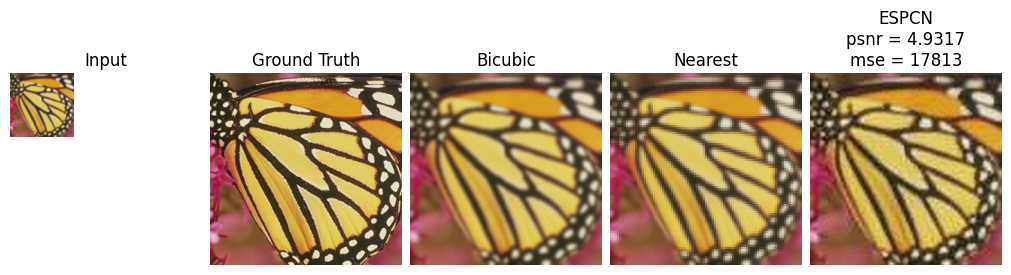

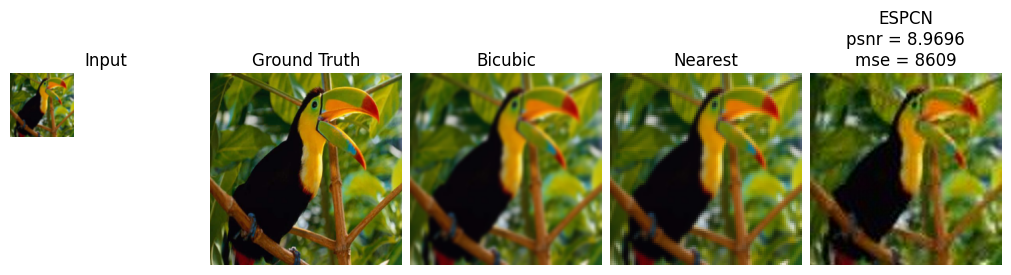

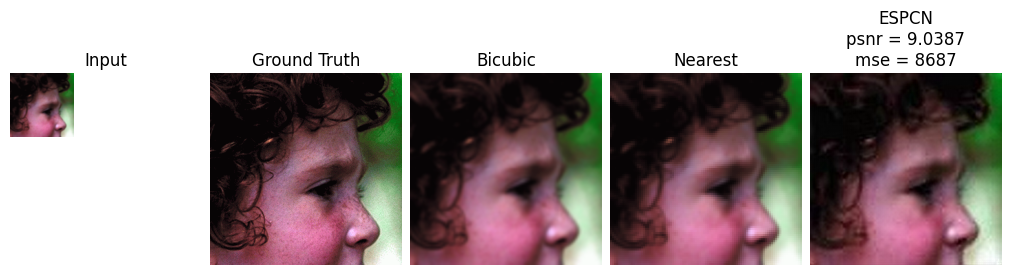

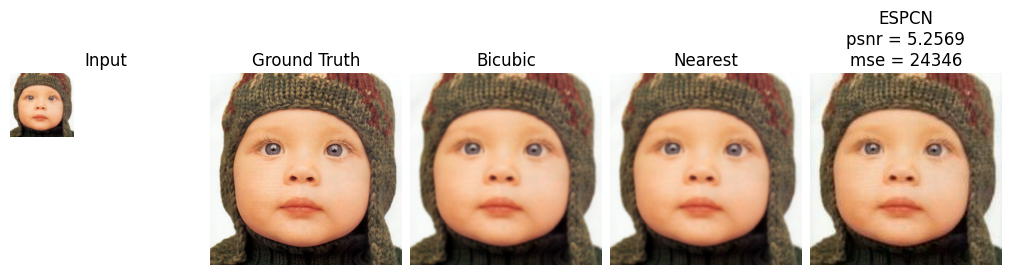

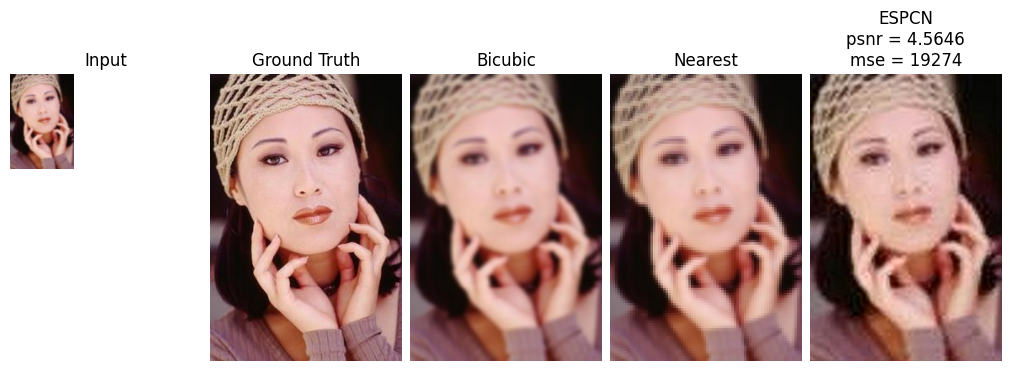

In [93]:
set5_path = "Images/Set5"
images = os.listdir(set5_path)


model = torch.load(
    ".models/model-500-ups-003.pth", weights_only=False
)

for img in images:
    img = os.path.join(set5_path, img)

    x = load_img(img)

    crop_size_h, crop_size_v = list(
        map(lambda cs: calculate_valid_crop_size(cs, 3), x.size)
    )

    target = torchvision.transforms.functional.to_tensor(load_img(img))
    target = torchvision.transforms.functional.center_crop(
        target, (crop_size_h, crop_size_v)
    )

    img_original = PIL.Image.open(img).copy()
    img_in = downsample_image(img, out="tmp/my_downsampled_image.jpg")
    fp_in = "tmp/my_downsampled_image.jpg"

    input, cb, cr = image_to_input(fp_in)

    out = model(input)
    img_out = output_to_image(out, cb, cr)

    psnr = peak_signal_noise_ratio(
        target.view(crop_size_h, crop_size_v), out.view(crop_size_h, crop_size_v)
    ).item()
    mse = mean_squared_error(
        target.view(crop_size_h, crop_size_v), out.view(crop_size_h, crop_size_v)
    ).item()

    img_bicubic = img_in.resize(img_out.size, PIL.Image.Resampling.BICUBIC)
    img_nearest = img_in.resize(img_out.size, PIL.Image.Resampling.NEAREST)

    img_out.save("tmp/asd.jpg")


    fig, axs = plt.subplots(
        1, 5, figsize=(10,4), sharex=True, sharey=True, constrained_layout=True
    )
    ax_iter = iter(axs)

    ax = next(ax_iter)
    ax.imshow(img_in)
    ax.set_title("Input")
    ax = next(ax_iter)
    ax.imshow(img_original)

    ax.set_title("Ground Truth")

    ax = next(ax_iter)
    ax.imshow(img_bicubic)
    ax.set_title("Bicubic")

    ax = next(ax_iter)
    ax.imshow(img_nearest)
    ax.set_title("Nearest")

    ax = next(ax_iter)
    ax.imshow(img_out)
    ax.set_title(f"ESPCN\n{psnr = :.4f}\n{mse = :.0f}")

    for ax in axs:
        ax.axis("off")  # remove the ticks

    plt.show()

### Filters visualization

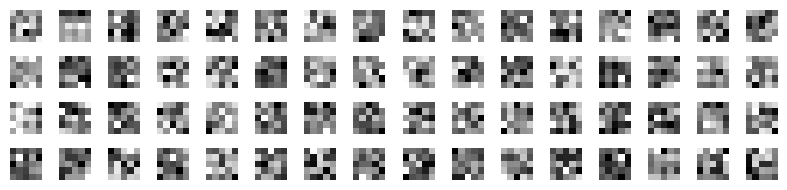

In [91]:
model: ESPCN = torch.load(
    ".models/model-100-ups-003.pth", weights_only=False
)

# first layer filter
filters = model.conv1.weight.detach()

grid_size = len(filters)

fig, axes = plt.subplots(4, 16, figsize=(8, 2))

for i, ax in enumerate(axes.flat):
    ax.imshow(filters[i][0].numpy(), cmap="gray")
    ax.axis("off")


plt.tight_layout()
plt.show()

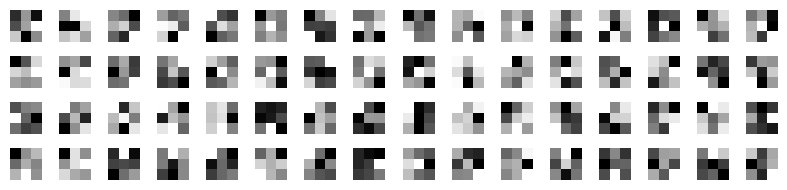

In [92]:
# second layer filter
filters = model.conv2.weight.detach()

grid_size = len(filters) 
fig, axes = plt.subplots(4, 16, figsize=(8, 2))

for i, ax in enumerate(axes.flat):
    ax.imshow(filters[i][0].numpy(), cmap='gray')  
    ax.axis('off') 


plt.tight_layout()
plt.show()